### aim: extract points corresponding to cael's points from model

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
import gsw
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)
import scipy.io


### load cael's fluxes

In [4]:
caelFluxes = scipy.io.loadmat('./fromCael/mouw_allfluxes.mat')

In [5]:
F_si_CAEL = (caelFluxes['S'])
F_ic_CAEL  = (caelFluxes['I'])
F_oc_CAEL = (caelFluxes['O'])
depth_CAEL  = (caelFluxes['Z'])
lat_CAEL = (caelFluxes['Y'])
lon_CAEL = (caelFluxes['X'])

### load our corresponding model coordinates found in ObsToGrid_JoeExample.ipynb

In [6]:
pts_TOM = pd.read_csv('CAELsedimentObsMappedToModelGrid_withlandflags.csv')

pts_TOM.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

pts_TOM.head()

,Unnamed: 0,Unnamed: 0.1,year,month,longitude,latitude,depth,POCflux,PICflux,PSiFlux,mod_Y,mod_X,mod_Z,on_land,on_land_at_surface,on_land_bc_too_deep
0,0,0,1991,7,179.0,58.0,3137,7.32,2.37,51.86,116.0,51.0,26,0,0,0
1,1,1,1991,8,179.0,58.0,3137,2.64,1.87,16.43,116.0,51.0,26,0,0,0
2,2,2,1991,9,179.0,58.0,3137,2.60,1.90,14.56,116.0,51.0,26,0,0,0
3,3,3,1991,9,179.0,58.0,3137,7.62,6.39,45.23,116.0,51.0,26,0,0,0
4,4,4,1991,10,179.0,58.0,3137,5.60,9.03,36.55,116.0,51.0,26,0,0,0


In [7]:
print(np.min(pts_TOM['year']))

1982


In [8]:
#convert to int arrays

on_land = pts_TOM['on_land'].values
mod_X = pts_TOM['mod_X'].values.astype(int)
mod_Y = (pts_TOM['mod_Y'].values).astype(int)
mod_Z = (pts_TOM['mod_Z'].values).astype(int)
mod_month = (pts_TOM['month'].values).astype(int) -1
cael_lat = (pts_TOM['latitude'].values).astype(int)
cael_lon = (pts_TOM['longitude'].values).astype(int)

print(f'we have {np.size(mod_X)} points in caels observational dataset')
print(f'we have {np.size(lat_CAEL)} points in caels observational dataset (checked with .matfile)')
print(f'of these {np.size(mod_X[on_land == 0])} map to water in the model without any adjustments')

we have 7159 points in caels observational dataset
we have 7159 points in caels observational dataset (checked with .matfile)
of these 6264 map to water in the model without any adjustments


## check that the obs we have in the matfile and in the csv are the same obs (should be)

Text(0, 0.5, 'PSiFlux from .csv')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


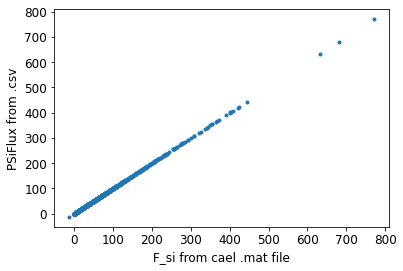

In [9]:
plt.scatter(F_si_CAEL, pts_TOM['PSiFlux'], marker = '.')
plt.xlabel('F_si from cael .mat file')
plt.ylabel('PSiFlux from .csv')

### let's check that our obs-to-grid matching alg puts things roughly at the right depth:
looks right - note that many depths will here map to the same bin

Text(0, 0.5, 'nominal depth of corresponding grid cell')

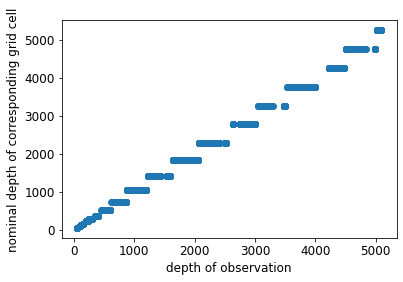

In [10]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tdepth = tmesh['gdept_1d'][0,:] 
Z_TOM = pts_TOM['mod_Z'].values
depth_TOM = tdepth[Z_TOM]

plt.figure()
plt.scatter(pts_TOM['depth'],depth_TOM)
plt.xlabel('depth of observation')
plt.ylabel('nominal depth of corresponding grid cell')

#### get model seawater density from TOM12_TJ_1ASA in order to be able to convert observations from µmol/kg to µmol/L

In [11]:
yr = 2000

Text(0.5, 1.0, 'sanity check, surface density (kg/m3), january')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


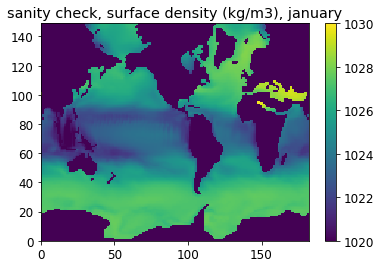

In [12]:
w = glob.glob(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_{yr}*grid_T.nc')
TJ1ASA_gridT = xr.open_mfdataset(w[0])

## get depths array of same dimensions as other arrays:
deptht_broad = np.zeros([12,31,149,182])
for i in range(0,31):
    deptht_broad[:,i,:,:] = TJ1ASA_gridT['deptht'][i]
    
vosaline_TJ1ASA = TJ1ASA_gridT['vosaline'].values
vosaline_psu_TJ1ASA = vosaline_TJ1ASA*35/35.16504 #convert from absolute salinity to practical salinity

votemper_TJ1ASA = TJ1ASA_gridT['votemper'].values

votemper_insitu_TJ1ASA = gsw.t_from_CT(np.ravel(vosaline_psu_TJ1ASA),np.ravel(votemper_TJ1ASA),np.ravel(deptht_broad))
votemper_insitu_TJ1ASA = votemper_insitu_TJ1ASA.reshape([12,31,149,182])

density_TJ1ASA = seawater.dens(np.ravel(vosaline_psu_TJ1ASA),np.ravel(votemper_insitu_TJ1ASA),np.ravel(deptht_broad))
density_TJ1ASA = density_TJ1ASA.reshape([12,31,149,182])

plt.figure()
plt.pcolormesh(density_TJ1ASA[0,0,:,:], vmin = 1020, vmax = 1030)
plt.colorbar()
plt.title('sanity check, surface density (kg/m3), january')
#plt.figure()
# plt.pcolormesh(density_TJ1ASA[0,0,:,:]-1000, vmin = 20, vmax = 30)
# plt.colorbar()
#plots for checking:
# plt.figure()
# plt.pcolormesh(votemper_insitu_TJ1ASA[0,0,:,:], vmin = -2, vmax = 30)
# plt.colorbar()
# plt.figure()
# plt.pcolormesh(votemper_TJ1ASA[0,0,:,:], vmin = -2, vmax = 30)
# plt.colorbar()
# plt.figure()
# plt.pcolormesh(votemper_TJ1ASA[0,0,:,:]-votemper_insitu_TJ1ASA[0,0,:,:])
# plt.colorbar()
# plt.figure()


## Load model data corresponding to Cael's points, preserving month, Z, Y, X but not year

- currently only extracting points that map to water

- From Jo: TOM12_JG_OCCA for the parameterised run and TOM12_JG_EB21 for the baseline (RIV12). i’ve been used the year 2000.

- also extract Si at 75 meters (closest bin to 80m) 

- save month, Z, Y, X, F_si, F_ic, F_oc, Si_umolkg

In [13]:

tnam = 'TOM12_JG_OCCA'
w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*diad_T.nc')
OCCA_diadT = xr.open_mfdataset(w[0])
w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
OCCA_ptrcT = xr.open_mfdataset(w[0])


# transform data from mol/m2/sec to mg/m2/day
EXP_xr_OCCA = (OCCA_diadT['EXP']*12*1e3*86400).values
ExpCO3_xr_OCCA = (OCCA_diadT['ExpCO3']*12*1e3*86400).values
sinksil_xr_OCCA = (OCCA_diadT['sinksil']*28*1e3*86400).values

F_si_OCCA = sinksil_xr_OCCA[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_ic_OCCA = ExpCO3_xr_OCCA[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_oc_OCCA = EXP_xr_OCCA[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]

w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
OCCA_ptrcT = xr.open_mfdataset(w[0])
Si_umolkg_OCCA_tot = OCCA_ptrcT['Si'].values*(1000/density_TJ1ASA) * 1e6 #umol/L * L/kg (slightly less than one)
depth_75 = np.zeros_like(mod_Z[on_land == 0])
depth_75[:] = 7
Si_umolkg_OCCA_75 = Si_umolkg_OCCA_tot[mod_month[on_land == 0],depth_75,mod_Y[on_land == 0], mod_X[on_land == 0]]

## map model data vs Cael's observational data

we see horizontal lines in the dataset - this phenomenon is because not all of cael's data map to unique points (either because of duplicate measurements or because there can be measurements at multiple depths that fall into the same model bin - a measurement at 23 m and a measurement at 26m would both fall into the bin whose depth is 25 m, for example). 

note therefore that these data are binned and not interpolated (so for an observation of depth 1200, we find the value in the model whose depth is closest to 1200, as opposed to interpolating between neighbouring depths). Given how deep these measurements are, it really shouldn't matter but we may need to think about doing it differently if necessary. it would be an extra step. 

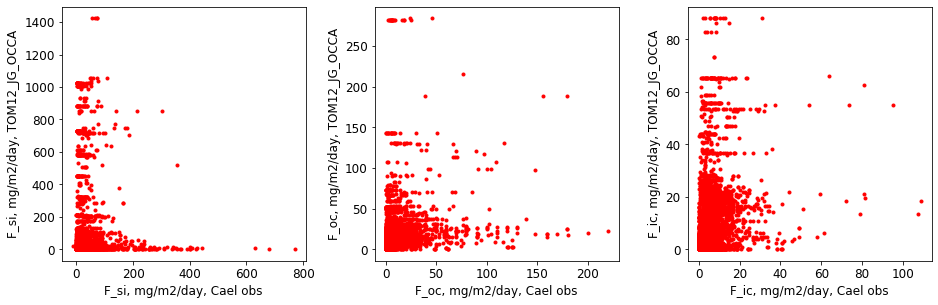

In [14]:

fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


axs[0].plot(F_si_CAEL[on_land == 0], F_si_OCCA, 'r.')
axs[0].set_xlabel('F_si, mg/m2/day, Cael obs')
axs[0].set_ylabel(f'F_si, mg/m2/day, {tnam}')

axs[1].plot(F_oc_CAEL[on_land == 0], F_oc_OCCA, 'r.')
axs[1].set_xlabel('F_oc, mg/m2/day, Cael obs')
axs[1].set_ylabel(f'F_oc, mg/m2/day, {tnam}')

axs[2].plot(F_ic_CAEL[on_land == 0], F_ic_OCCA, 'r.')
axs[2].set_xlabel('F_ic, mg/m2/day, Cael obs')
axs[2].set_ylabel(f'F_ic, mg/m2/day, {tnam}')

plt.tight_layout()

### let's check that there are no 0s in our model dataset (cells that map to water in teh model only):

In [15]:
print(f'lowest 5 values of F_si_OCCA {np.sort(F_si_OCCA)[0:5]}')
print(f'lowest 5 values of F_ic_OCCA {np.sort(F_ic_OCCA)[0:5]}')
print(f'lowest 5 values of F_oc_OCCA {np.sort(F_oc_OCCA)[0:5]}')

lowest 5 values of F_si_OCCA [0.0003364  0.00043581 0.00043581 0.00044052 0.00044052]
lowest 5 values of F_ic_OCCA [7.05591845e-06 1.00142604e-05 1.12131052e-05 1.53812219e-05
 1.85888876e-05]
lowest 5 values of F_oc_OCCA [0.02443604 0.02443604 0.02714195 0.02714195 0.02737857]


## save into csv

In [16]:
mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]

tmod_Z = mod_Z[on_land == 0]
tmod_Y = mod_Y[on_land == 0]
tmod_X = mod_X[on_land == 0]
tlat = (lat_CAEL[on_land == 0][:,0])
tlon = (lon_CAEL[on_land == 0][:,0])
tmod_month = mod_month[on_land == 0]
F_si = F_si_OCCA
F_ic = F_ic_OCCA
F_oc = F_oc_OCCA
Si_umolkg = Si_umolkg_OCCA_75

df = pd.DataFrame([tmod_Z,tmod_Y,tmod_X, tlat, tlon, tmod_month, F_si, F_ic, F_oc, Si_umolkg]).T
    # df = df.sort_values(by = tYEAR_SO)
df.columns = ['tmod_Z','tmod_Y','tmod_X', 'tlat', 'tlon', 'tmod_month', 'F_si', 'F_ic', 'F_oc', 'Si_umolkg']
df.wheremade = 'SOZONE/BallastingCael/extractCaelCorrPointsFromModel.ipynb'
df.to_csv(f'./extractedFromModel/sinkdata_{tnam}_y{yr}.csv')

# do the exact same process for TOM12_JG_EB21

lowest 5 values of F_si [0.00037344 0.0004533  0.0004533  0.00046662 0.00046662]
lowest 5 values of F_ic [5.15613614e-08 5.15613614e-08 5.15613614e-08 5.15613614e-08
 5.15613614e-08]
lowest 5 values of F_oc [0.38757825 0.38757825 0.44798724 0.51659821 0.51659821]


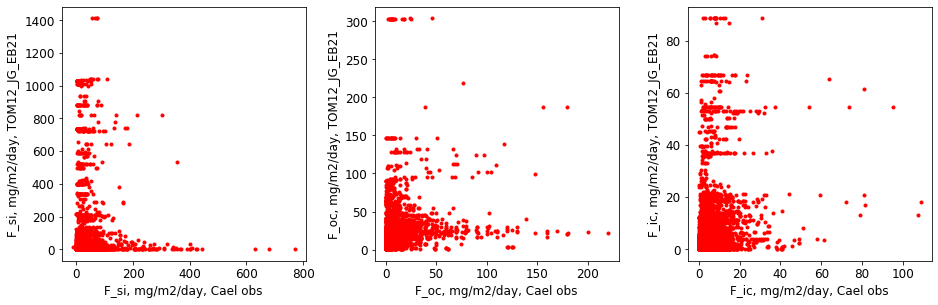

In [17]:

tnam = 'TOM12_JG_EB21'
w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*diad_T.nc')
EB21_diadT = xr.open_mfdataset(w[0])
w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
EB21_ptrcT = xr.open_mfdataset(w[0])


# transform data from mol/m2/sec to mg/m2/day
EXP_xr_EB21 = (EB21_diadT['EXP']*12*1e3*86400).values
ExpCO3_xr_EB21 = (EB21_diadT['ExpCO3']*12*1e3*86400).values
sinksil_xr_EB21 = (EB21_diadT['sinksil']*28*1e3*86400).values

F_si_EB21 = sinksil_xr_EB21[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_ic_EB21 = ExpCO3_xr_EB21[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_oc_EB21 = EXP_xr_EB21[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]

w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
EB21_ptrcT = xr.open_mfdataset(w[0])
Si_umolkg_EB21_tot = EB21_ptrcT['Si'].values*(1000/density_TJ1ASA) * 1e6 #umol/L * L/kg (slightly less than one)
depth_75 = np.zeros_like(mod_Z[on_land == 0])
depth_75[:] = 7
Si_umolkg_EB21_75 = Si_umolkg_EB21_tot[mod_month[on_land == 0],depth_75,mod_Y[on_land == 0], mod_X[on_land == 0]]

### plot
fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(F_si_CAEL[on_land == 0], F_si_EB21, 'r.')
axs[0].set_xlabel('F_si, mg/m2/day, Cael obs')
axs[0].set_ylabel(f'F_si, mg/m2/day, {tnam}')

axs[1].plot(F_oc_CAEL[on_land == 0], F_oc_EB21, 'r.')
axs[1].set_xlabel('F_oc, mg/m2/day, Cael obs')
axs[1].set_ylabel(f'F_oc, mg/m2/day, {tnam}')

axs[2].plot(F_ic_CAEL[on_land == 0], F_ic_EB21, 'r.')
axs[2].set_xlabel('F_ic, mg/m2/day, Cael obs')
axs[2].set_ylabel(f'F_ic, mg/m2/day, {tnam}')

plt.tight_layout()

print(f'lowest 5 values of F_si {np.sort(F_si_EB21)[0:5]}')
print(f'lowest 5 values of F_ic {np.sort(F_ic_EB21)[0:5]}')
print(f'lowest 5 values of F_oc {np.sort(F_oc_EB21)[0:5]}')

mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]

tmod_Z = mod_Z[on_land == 0]
tmod_Y = mod_Y[on_land == 0]
tmod_X = mod_X[on_land == 0]
tlat = (lat_CAEL[on_land == 0][:,0])
tlon = (lon_CAEL[on_land == 0][:,0])
tmod_month = mod_month[on_land == 0]
F_si = F_si_EB21
F_ic = F_ic_EB21
F_oc = F_oc_EB21
Si_umolkg = Si_umolkg_EB21_75

df = pd.DataFrame([tmod_Z,tmod_Y,tmod_X, tlat, tlon, tmod_month, F_si, F_ic, F_oc, Si_umolkg]).T
    # df = df.sort_values(by = tYEAR_SO)
df.columns = ['tmod_Z','tmod_Y','tmod_X', 'tlat', 'tlon', 'tmod_month', 'F_si', 'F_ic', 'F_oc', 'Si_umolkg']
df.wheremade = 'SOZONE/BallastingCael/extractCaelCorrPointsFromModel.ipynb'
df.to_csv(f'./extractedFromModel/sinkdata_{tnam}_y{yr}.csv')

lowest 5 values of F_si [0.00110111 0.00110111 0.00127178 0.00127178 0.00127178]
lowest 5 values of F_ic [5.88747652e-14 5.88747652e-14 5.88747652e-14 5.88747652e-14
 5.88747652e-14]
lowest 5 values of F_oc [0.01351119 0.01351119 0.01400462 0.01400462 0.01400462]


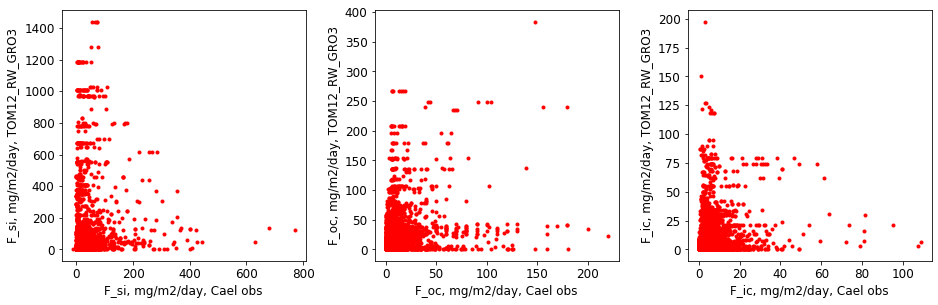

In [18]:

tnam = 'TOM12_RW_GRO3'
w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*diad_T.nc')
GR03_diadT = xr.open_mfdataset(w[0])
w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
GR03_ptrcT = xr.open_mfdataset(w[0])


# transform data from mol/m2/sec to mg/m2/day
EXP_xr_GR03 = (GR03_diadT['EXP']*12*1e3*86400).values
ExpCO3_xr_GR03 = (GR03_diadT['ExpCO3']*12*1e3*86400).values
sinksil_xr_GR03 = (GR03_diadT['sinksil']*28*1e3*86400).values

F_si_GR03 = sinksil_xr_GR03[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_ic_GR03 = ExpCO3_xr_GR03[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_oc_GR03 = EXP_xr_GR03[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]

w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
GR03_ptrcT = xr.open_mfdataset(w[0])
Si_umolkg_GR03_tot = GR03_ptrcT['Si'].values*(1000/density_TJ1ASA) * 1e6 #umol/L * L/kg (slightly less than one)
depth_75 = np.zeros_like(mod_Z[on_land == 0])
depth_75[:] = 7
Si_umolkg_GR03_75 = Si_umolkg_GR03_tot[mod_month[on_land == 0],depth_75,mod_Y[on_land == 0], mod_X[on_land == 0]]

### plot
fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(F_si_CAEL[on_land == 0], F_si_GR03, 'r.')
axs[0].set_xlabel('F_si, mg/m2/day, Cael obs')
axs[0].set_ylabel(f'F_si, mg/m2/day, {tnam}')

axs[1].plot(F_oc_CAEL[on_land == 0], F_oc_GR03, 'r.')
axs[1].set_xlabel('F_oc, mg/m2/day, Cael obs')
axs[1].set_ylabel(f'F_oc, mg/m2/day, {tnam}')

axs[2].plot(F_ic_CAEL[on_land == 0], F_ic_GR03, 'r.')
axs[2].set_xlabel('F_ic, mg/m2/day, Cael obs')
axs[2].set_ylabel(f'F_ic, mg/m2/day, {tnam}')

plt.tight_layout()

print(f'lowest 5 values of F_si {np.sort(F_si_GR03)[0:5]}')
print(f'lowest 5 values of F_ic {np.sort(F_ic_GR03)[0:5]}')
print(f'lowest 5 values of F_oc {np.sort(F_oc_GR03)[0:5]}')

mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]

tmod_Z = mod_Z[on_land == 0]
tmod_Y = mod_Y[on_land == 0]
tmod_X = mod_X[on_land == 0]
tlat = (lat_CAEL[on_land == 0][:,0])
tlon = (lon_CAEL[on_land == 0][:,0])
tmod_month = mod_month[on_land == 0]
F_si = F_si_GR03
F_ic = F_ic_GR03
F_oc = F_oc_GR03
Si_umolkg = Si_umolkg_GR03_75

df = pd.DataFrame([tmod_Z,tmod_Y,tmod_X, tlat, tlon, tmod_month, F_si, F_ic, F_oc, Si_umolkg]).T
    # df = df.sort_values(by = tYEAR_SO)
df.columns = ['tmod_Z','tmod_Y','tmod_X', 'tlat', 'tlon', 'tmod_month', 'F_si', 'F_ic', 'F_oc', 'Si_umolkg']
df.wheremade = 'SOZONE/BallastingCael/extractCaelCorrPointsFromModel.ipynb'
df.to_csv(f'./extractedFromModel/sinkdata_{tnam}_y{yr}.csv')

['/gpfs/home/vsz14eru/scratch/models/ModelRuns/TOM12_JG_GRO7/ORCA2_1m_19550101_19551231_diad_T.nc']
lowest 5 values of F_si [0.00576969 0.0079788  0.00829854 0.00875823 0.00875823]
lowest 5 values of F_ic [1.91190083e-07 1.91190083e-07 1.91190083e-07 1.91190083e-07
 1.91190083e-07]
lowest 5 values of F_oc [0.03421669 0.04773643 0.04773643 0.04873777 0.04873777]


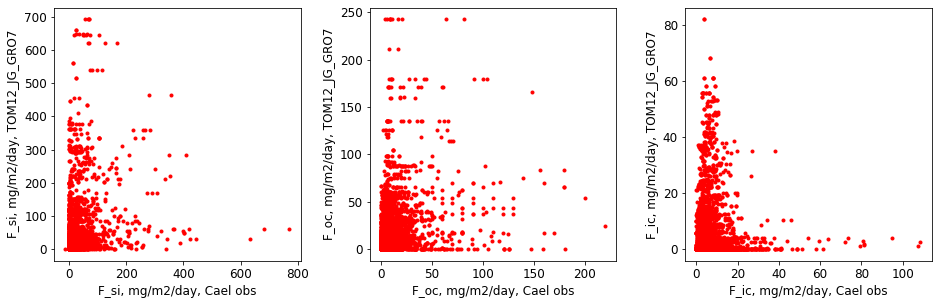

In [25]:
yr = 1955
tnam = 'TOM12_JG_GRO7'
w = glob.glob(f'/gpfs/home/vsz14eru/scratch/models/ModelRuns/{tnam}/ORCA2_1m_{yr}*diad_T.nc')
print(w)
GRO7_diadT = xr.open_mfdataset(w[0])
w = glob.glob(f'/gpfs/home/vsz14eru/scratch/models/ModelRuns/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
GRO7_ptrcT = xr.open_mfdataset(w[0])


# transform data from mol/m2/sec to mg/m2/day
EXP_xr_GRO7 = (GRO7_diadT['EXP']*12*1e3*86400).values
ExpCO3_xr_GRO7 = (GRO7_diadT['ExpCO3']*12*1e3*86400).values
sinksil_xr_GRO7 = (GRO7_diadT['sinksil']*28*1e3*86400).values

F_si_GRO7 = sinksil_xr_GRO7[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_ic_GRO7 = ExpCO3_xr_GRO7[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]
F_oc_GRO7 = EXP_xr_GRO7[mod_month[on_land == 0],mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]]

w = glob.glob(f'/gpfs/data/greenocean/software/runs/{tnam}/ORCA2_1m_{yr}*ptrc_T.nc')
GRO7_ptrcT = xr.open_mfdataset(w[0])
Si_umolkg_GRO7_tot = GRO7_ptrcT['Si'].values*(1000/density_TJ1ASA) * 1e6 #umol/L * L/kg (slightly less than one)
depth_75 = np.zeros_like(mod_Z[on_land == 0])
depth_75[:] = 7
Si_umolkg_GRO7_75 = Si_umolkg_GRO7_tot[mod_month[on_land == 0],depth_75,mod_Y[on_land == 0], mod_X[on_land == 0]]

### plot
fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(F_si_CAEL[on_land == 0], F_si_GRO7, 'r.')
axs[0].set_xlabel('F_si, mg/m2/day, Cael obs')
axs[0].set_ylabel(f'F_si, mg/m2/day, {tnam}')

axs[1].plot(F_oc_CAEL[on_land == 0], F_oc_GRO7, 'r.')
axs[1].set_xlabel('F_oc, mg/m2/day, Cael obs')
axs[1].set_ylabel(f'F_oc, mg/m2/day, {tnam}')

axs[2].plot(F_ic_CAEL[on_land == 0], F_ic_GRO7, 'r.')
axs[2].set_xlabel('F_ic, mg/m2/day, Cael obs')
axs[2].set_ylabel(f'F_ic, mg/m2/day, {tnam}')

plt.tight_layout()

print(f'lowest 5 values of F_si {np.sort(F_si_GRO7)[0:5]}')
print(f'lowest 5 values of F_ic {np.sort(F_ic_GRO7)[0:5]}')
print(f'lowest 5 values of F_oc {np.sort(F_oc_GRO7)[0:5]}')

mod_Z[on_land == 0],mod_Y[on_land == 0], mod_X[on_land == 0]

tmod_Z = mod_Z[on_land == 0]
tmod_Y = mod_Y[on_land == 0]
tmod_X = mod_X[on_land == 0]
tlat = (lat_CAEL[on_land == 0][:,0])
tlon = (lon_CAEL[on_land == 0][:,0])
tmod_month = mod_month[on_land == 0]
F_si = F_si_GRO7
F_ic = F_ic_GRO7
F_oc = F_oc_GRO7
Si_umolkg = Si_umolkg_GRO7_75

df = pd.DataFrame([tmod_Z,tmod_Y,tmod_X, tlat, tlon, tmod_month, F_si, F_ic, F_oc, Si_umolkg]).T
    # df = df.sort_values(by = tYEAR_SO)
df.columns = ['tmod_Z','tmod_Y','tmod_X', 'tlat', 'tlon', 'tmod_month', 'F_si', 'F_ic', 'F_oc', 'Si_umolkg']
df.wheremade = 'SOZONE/BallastingCael/extractCaelCorrPointsFromModel.ipynb'
df.to_csv(f'./extractedFromModel/sinkdata_{tnam}_y{yr}.csv')

In [26]:
tdat = np.random.rand(100)
nbins = 10
start = 0
end = 1


def custhist(tdat, nbins, start, end, tweights = None):
    #bins = 25
    hist_met_vflx, bins = np.histogram(np.ravel(tdat), bins=nbins,\
                                 range = [start, end], weights=tweights)

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)

    
    binsback = bins
    bin_cent = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    
    return binsback, bin_cent, histback

nsback, bin_cent, histback = custhist(tdat, nbins, start, end)
#plt.plot(bin_cent,histback)

In [27]:
caelSi = scipy.io.loadmat('./fromCael/cael_Si80.mat')

Si80_CAEL = np.transpose(np.array(caelSi['Si80']))
#print(np.nanmax(caelSi['Si80']))

In [28]:
np.shape(F_si_CAEL)

(7159, 1)

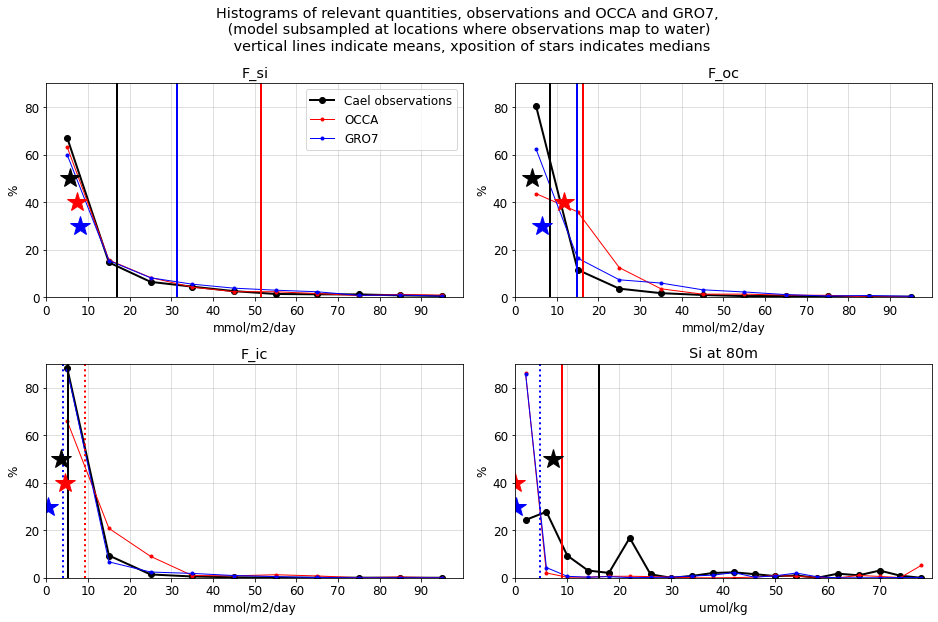

In [29]:

F_si_CAEL[on_land == 0]



fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

F_si_max = 100
nsback, bin_cent, histback = custhist(F_si_CAEL[on_land == 0], 10, 0, F_si_max)
axs[0].plot(bin_cent,histback*100, color = 'k', linewidth = 2, marker = 'o', label = 'Cael observations')
nsback, bin_cent, histback = custhist(F_si_OCCA, 10, 0, 100)
axs[0].plot(bin_cent,histback*100, color = 'r', linewidth = 1, marker = '.', label = 'OCCA')
nsback, bin_cent, histback = custhist(F_si_GRO7, 10, 0, 100)
axs[0].plot(bin_cent,histback*100, color = 'b', linewidth = 1, marker = '.', label = 'GRO7')
axs[0].axvline(np.nanmean(F_si_CAEL[on_land == 0]), color = 'k', linewidth = 2)
axs[0].axvline(np.nanmean(F_si_OCCA), color = 'r', linewidth = 2)
axs[0].axvline(np.nanmean(F_si_GRO7), color = 'b', linewidth = 2)
axs[0].plot(np.nanmedian(F_si_CAEL[on_land == 0]),50, color = 'k', marker = '*', markersize = 20)
axs[0].plot(np.median(F_si_OCCA),40, color = 'r',  marker = '*', markersize = 20)
axs[0].plot(np.median(F_si_GRO7),30, color = 'b',  marker = '*', markersize = 20)

F_oc_max = 100
nsback, bin_cent, histback = custhist(F_oc_CAEL[on_land == 0], 10, 0, F_oc_max)
axs[1].plot(bin_cent,histback*100, color = 'k', linewidth = 2, marker = 'o')
nsback, bin_cent, histback = custhist(F_oc_OCCA, 10, 0, F_oc_max)
axs[1].plot(bin_cent,histback*100, color = 'r', linewidth = 1, marker = '.', label = 'OCCA')
nsback, bin_cent, histback = custhist(F_oc_GRO7, 10, 0, F_oc_max)
axs[1].plot(bin_cent,histback*100, color = 'b', linewidth = 1, marker = '.', label = 'GRO7')
axs[1].axvline(np.nanmean(F_oc_CAEL[on_land == 0]), color = 'k', linewidth = 2)
axs[1].axvline(np.nanmean(F_oc_OCCA), color = 'r', linewidth = 2)
axs[1].axvline(np.nanmean(F_oc_GRO7), color = 'b', linewidth = 2)
axs[1].plot(np.nanmedian(F_oc_CAEL[on_land == 0]),50, color = 'k', marker = '*', markersize = 20)
axs[1].plot(np.median(F_oc_OCCA),40, color = 'r',  marker = '*', markersize = 20)
axs[1].plot(np.median(F_oc_GRO7),30, color = 'b',  marker = '*', markersize = 20)

F_ic_max = 100
nsback, bin_cent, histback = custhist(F_ic_CAEL[on_land == 0], 10, 0, F_ic_max)
axs[2].plot(bin_cent,histback*100, color = 'k', linewidth = 2, marker = 'o')
nsback, bin_cent, histback = custhist(F_ic_OCCA, 10, 0, F_ic_max)
axs[2].plot(bin_cent,histback*100, color = 'r', linewidth = 1, marker = '.', label = 'OCCA')
nsback, bin_cent, histback = custhist(F_ic_GRO7, 10, 0, F_ic_max)
axs[2].plot(bin_cent,histback*100, color = 'b', linewidth = 1, marker = '.', label = 'GRO7')
axs[2].axvline(np.nanmean(F_ic_CAEL[on_land == 0]), color = 'k', linewidth = 2)
axs[2].axvline(np.nanmean(F_ic_OCCA), color = 'r', linewidth = 2, linestyle = ':')
axs[2].axvline(np.nanmean(F_ic_GRO7), color = 'b', linewidth = 2, linestyle = ':')
axs[2].plot(np.nanmedian(F_ic_CAEL[on_land == 0]),50, color = 'k', marker = '*', markersize = 20)
axs[2].plot(np.median(F_ic_OCCA),40, color = 'r',  marker = '*', markersize = 20)
axs[2].plot(np.median(F_ic_GRO7),30, color = 'b',  marker = '*', markersize = 20)


Si_max = 80
nsback, bin_cent, histback = custhist(Si80_CAEL[on_land == 0], 20, 0, Si_max)
axs[3].plot(bin_cent,histback*100, color = 'k', linewidth = 2, marker = 'o')
nsback, bin_cent, histback = custhist(Si_umolkg_OCCA_75, 20, 0, Si_max)
axs[3].plot(bin_cent,histback*100, color = 'r', linewidth = 1, marker = '.', label = 'OCCA')
nsback, bin_cent, histback = custhist(Si_umolkg_GRO7_75, 20, 0, Si_max)
axs[3].plot(bin_cent,histback*100, color = 'b', linewidth = 1, marker = '.', label = 'GRO7')
axs[3].axvline(np.nanmean(Si80_CAEL[on_land == 0]), color = 'k', linewidth = 2)
axs[3].axvline(np.nanmean(Si_umolkg_OCCA_75), color = 'r', linewidth = 2)
axs[3].axvline(np.nanmean(Si_umolkg_GRO7_75), color = 'b', linewidth = 2, linestyle =':')
axs[3].plot(np.nanmedian(Si80_CAEL[on_land == 0]),50, color = 'k', marker = '*', markersize = 20)
axs[3].plot(np.median(Si_umolkg_OCCA_75),40, color = 'r',  marker = '*', markersize = 20)
axs[3].plot(np.median(Si_umolkg_GRO7_75),30, color = 'b',  marker = '*', markersize = 20)

tits = ['F_si', 'F_oc', 'F_ic', 'Si at 80m']
for i in range(0,4):
    axs[i].set_ylim([0,90])
    axs[i].set_xlim([0,100])
    axs[i].set_xticks(np.arange(0,100,10))
    axs[i].grid(alpha = 0.5)
    axs[i].set_ylabel('%')
    axs[i].set_title(tits[i])
    axs[i].set_xlabel('mmol/m2/day')
    axs[3].set_xlabel('umol/kg')
    axs[3].set_xlim([0,80])
    axs[3].set_xticks(np.arange(0,80,10))
    axs[0].legend()
    
plt.suptitle('Histograms of relevant quantities, observations and OCCA and GRO7, \n (model subsampled at locations where observations map to water) \n vertical lines indicate means, xposition of stars indicates medians')

plt.tight_layout()

In [ ]:
print('median, Si, umol/kg')
print(f'')
print(f'GR03 {np.median(Si_umolkg_GR03_75)}')
print(f'OCCA {np.median(Si_umolkg_OCCA_75)}')
print(np.shape(Si_umolkg_GR03_75))
print(np.shape(Si_umolkg_GR03_75[Si_umolkg_GR03_75<5]))

In [ ]:
np.median(Si80_CAEL[on_land == 0])